# PHI Data Tutorial

## Solar Orbiter Meeting @ GSFC - 25th October 2022

### Jonas Sinjan (PhD Student at Max Planck Institute for Solar System Research, Goettingen, Germany)

#### For questions you can reach me by email: sinjan@mps.mpg.de

#### *with many thanks to the SO/PHI team*

<img src="./static/philogo-1.png" width="220" align="left"/>


----

## Useful Links and Information

- [SO/PHI Data Releases and Publication](https://www.mps.mpg.de/solar-physics/solar-orbiter-phi/data-releases)
- [SO/PHI-FDT Quick Look Data](https://www.uv.es/jublanro/phidata_fdt.html)
- [SO/PHI-HRT Quick Look Data](https://www.uv.es/jublanro/phidata_hrt.html)
- [SO/PHI Data Format and Tutorials](https://www.mps.mpg.de/solar-physics/solar-orbiter-phi/data)
- [SO/PHI Instrument Information](https://www.mps.mpg.de/solar-physics/solar-orbiter-phi)
- [SOAR](https://soar.esac.esa.int/soar/#search)
- [SOAR Inventory Plots](https://www.cosmos.esa.int/web/soar/inventory-plots)
- [SOAR Python Download Github Gist](https://gist.github.com/JonasSinjan/e10053b972e5fb72057c078c7c275a5e)

----

## Instrument Basics and Key Properties

- Two telescopes:
  - HRT (High Resolution Telescope)
  - FDT (Full Disc Telescope)
- FDT always has full disc within FOV
- HRT has much smaller FOV with much higher resolution
- They cannot operate simultaneously
- They are not continuously operating -> check quick look links above to see when Data is available
- They work in a very similar way to SDO/HMI -> for a comparison see: [SDO/HMI - SO/PHI-HRT Comparison](https://doi.org/10.1051/0004-6361/202245830)
- If you have ideas for scientific campaigns - get in contact via: `sophi_support@mps.mpg.de`

![Alt Text](./static/sophi_fov_rotateSun_new.gif)
----

## Setup and Installation (Currently the .yml file has not yet been tested - please manually install the packages via pip or conda)

Tested OS:
- Linux Ubuntu

```bash=
conda env create --name phi_tutorial --file=phi_tutorial.yml
```

Otherwise manually install packages listed in `requirements.txt` with pip

### Troubleshooting

If the environment `phi_tutorial` does not appear as a kernel in Jupyter Notebooks:

```bash=
conda activate phi_tutorial
pip install ipykernel
python -m ipykernel install --user --name phi_tutorial --display-name "Python (phi_tutorial)"
```

----

In [1]:
import sunpy.map

import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np

import astropy
from astropy.io import fits
from astropy import units as u

from helper_functions import plot_hrt_phys_obs, get_wv_arr_and_ic_wv, plot_hrt_stokes, plot_hrt_noise_both

In [2]:
%matplotlib inline

In [3]:
print('astropy version:', astropy.__version__)
print('sunpy version: ', sunpy.__version__)

astropy version: 5.0.1
sunpy version:  3.1.4


# 1. SOAR load data example

First we will load SO/PHI-HRT and SO/PHI-FDT Data from the SOAR (Solar Orbiter Archive) using `sunpy` and `sunpy_soar`.

## SO/PHI-HRT (High Resolution Telescope)

This is searching for data around the time of the Inferior Sun conjunction (when Solar Orbiter crossed the Sun-Earth line)

In [3]:
data_dir = './data/'

In [ ]:
import sunpy_soar
from sunpy.net import Fido, attrs as a
from astropy.time import Time

######## Download all SO/PHI-HRT Data Products (can be slow) ########

t_start_hrt = Time('2022-03-07T00:00', format='isot', scale='utc')
t_end_hrt = Time('2022-03-07T00:01', format='isot', scale='utc')

results_phi_hrt = Fido.search(a.Instrument('PHI'), a.Time(t_start_hrt.value, t_end_hrt.value)) #a.soar.Product('phi-hrt-blos')
files_phi_hrt = Fido.fetch(results_phi_hrt, path=data_dir)

######## Download just one SO/PHI-HRT Data Product ########

"""
t_start_hrt = Time('2022-03-07T00:00', format='isot', scale='utc')
t_end_hrt = Time('2022-03-07T00:01', format='isot', scale='utc')

results_phi_hrt = Fido.search(a.Instrument('PHI'), a.Time(t_start_hrt.value, t_end_hrt.value), a.soar.Product('phi-hrt-blos'))
files_phi_hrt = Fido.fetch(results_phi_hrt, path=data_dir)
"""

"""
PHI SOAR product Codes: (Check SOAR website - as these may change)

HRT (High Resolution Telescope)
'phi-hrt-blos'
'phi-hrt-bmag'
'phi-hrt-binc'
'phi-hrt-bazi'
'phi-hrt-icnt'
'phi-hrt-stokes'
'phi-hrt-vlos'

FDT (Full Disc Telescope)

Currently only the continuum Intensity and Line-of-sight Magnetic Field (Blos) have been released to SOAR for FDT

'phi-fdt-blos'
'phi-fdt-icnt'

In Future additionally:

'phi-fdt-bmag'
'phi-fdt-binc'
'phi-fdt-bazi'
'phi-fdt-stokes'
'phi-fdt-vlos'
"""

### load directly from fits files

- notice the `"_V01"` suffix
- over time the calibration will improve and data will be reprocessed and republished under higher versions, ie: `"_V02"` etc.
- this way you can keep track of which version of the data you used
- for information about the different data products -> see the `"SO/PHI Data Format and Tutorials"` link above 

In [4]:

hrt_blos = fits.getdata(data_dir + "solo_L2_phi-hrt-blos_20220307T000009_V01.fits")
hrt_bmag = fits.getdata(data_dir + "solo_L2_phi-hrt-bmag_20220307T000009_V01.fits")
hrt_binc = fits.getdata(data_dir + "solo_L2_phi-hrt-binc_20220307T000009_V01.fits")
hrt_bazi = fits.getdata(data_dir + "solo_L2_phi-hrt-bazi_20220307T000009_V01.fits")
hrt_vlos = fits.getdata(data_dir + "solo_L2_phi-hrt-vlos_20220307T000009_V01.fits")
hrt_icnt = fits.getdata(data_dir + "solo_L2_phi-hrt-icnt_20220307T000009_V01.fits")
hrt_stokes = fits.getdata(data_dir + "solo_L2_phi-hrt-stokes_20220307T000009_V01.fits")

In [12]:
hrt_stokes.shape

(2048, 2048, 4, 6)

Quick peek of the SO/PHI-HRT line-of-sight magnetogram via `sunpy.map.Map`:

In [8]:
hrt_blos_map = sunpy.map.Map(data_dir + "solo_L2_phi-hrt-blos_20220307T000009_V01.fits")

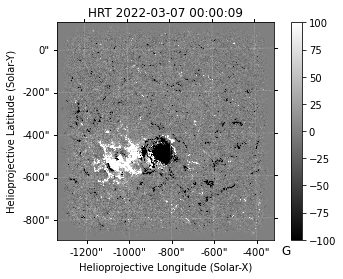

In [9]:
hrt_blos_map.plot_settings['norm'].vmin = -100
hrt_blos_map.plot_settings['norm'].vmax = 100
hrt_blos_map.peek()

## FDT (Full Disc Telescope)

In [ ]:
######## Download FDT Data ########

t_start_fdt = Time('2022-01-31T14:30', format='isot', scale='utc')
t_end_fdt = Time('2022-01-31T14:31', format='isot', scale='utc')

results_phi_fdt = Fido.search(a.Instrument('PHI'), a.Time(t_start_fdt.value, t_end_fdt.value), a.soar.Product('phi-fdt-blos'))
files_phi_fdt = Fido.fetch(results_phi_fdt, path=data_dir)

results_phi_fdt = Fido.search(a.Instrument('PHI'), a.Time(t_start_fdt.value, t_end_fdt.value), a.soar.Product('phi-fdt-icnt'))
files_phi_fdt = Fido.fetch(results_phi_fdt, path=data_dir)

In [6]:
#load directly from fits files as backup
fdt_blos = fits.getdata(data_dir + "solo_L2_phi-fdt-blos_20220131T143008_V01.fits")
fdt_icnt = fits.getdata(data_dir + "solo_L2_phi-fdt-icnt_20220131T143008_V01.fits")

Sunpy integration here is important. These fits files can be read into `sunpy` `Map` objects, like you have seen earlier.

In [7]:
fdt_blos_map = sunpy.map.Map(data_dir + "solo_L2_phi-fdt-blos_20220131T143008_V01.fits")
fdt_blos_map.plot_settings['norm'].vmin = -100
fdt_blos_map.plot_settings['norm'].vmax = 100 
fdt_blos_map.plot_settings['cmap'] = plt.get_cmap('gray')

In [8]:
#rotate FDT for Solar North to point straight up
fdt_blos_map = fdt_blos_map.rotate(recenter = True)

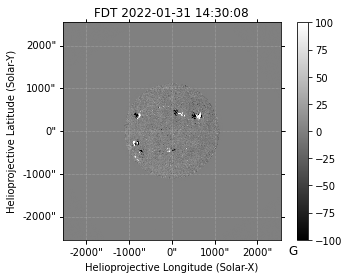

In [9]:
fdt_blos_map.peek()

## Data size

Each data product is 2048 x 2048 pixels (16MB for 32bit pixels) 

The polarimetry data: "Stokes" files are an exception however:

- HRT: it is a datacube of: 2048 x 2048 x 4 x 6 (384MB for 32bit pixels) -> this means it cannot be loaded directly into ds9
- FDT: it is a datacube of: 6 x 4 x 2048 x 2048 (384MB for 32bit pixels)

The HRT stokes file will be changed in the future to match axis of the FDT

However there are times when the files are cropped, as only part of the FOV is of interest, in which case the file sizes are smaller.

The FDT data files which we use here are cropped to the central 1024 x 1024 pixels

## 2. L2 SO/PHI Data Products (Physical Observables)

The physical observables that SO/PHI creates for both telescopes: HRT and FDT, at the L2 level are:

- Continuum Intensity *[Normalised Intensity (No Unit)]*
- Vector Magnetic Field **B**:
    - Magnetic Field Strength *[Gauss]*
    - Magnetic Field Inclination *[Degrees]*
    - Magnetic Field Azimuth (Ambiguated) *[Degrees]*
- Line-of-sight Magnetic Field (Blos) *[Gauss]*
- Line-of-sight Velocity *[km/s]*

For SO/PHI-FDT currently only the continuum Intensity and Line-of-sight Magnetic Field (Blos) have been released to SOAR

## HRT

- The black edge here is the field stop region of HRT (not in the FOV of the telescope)

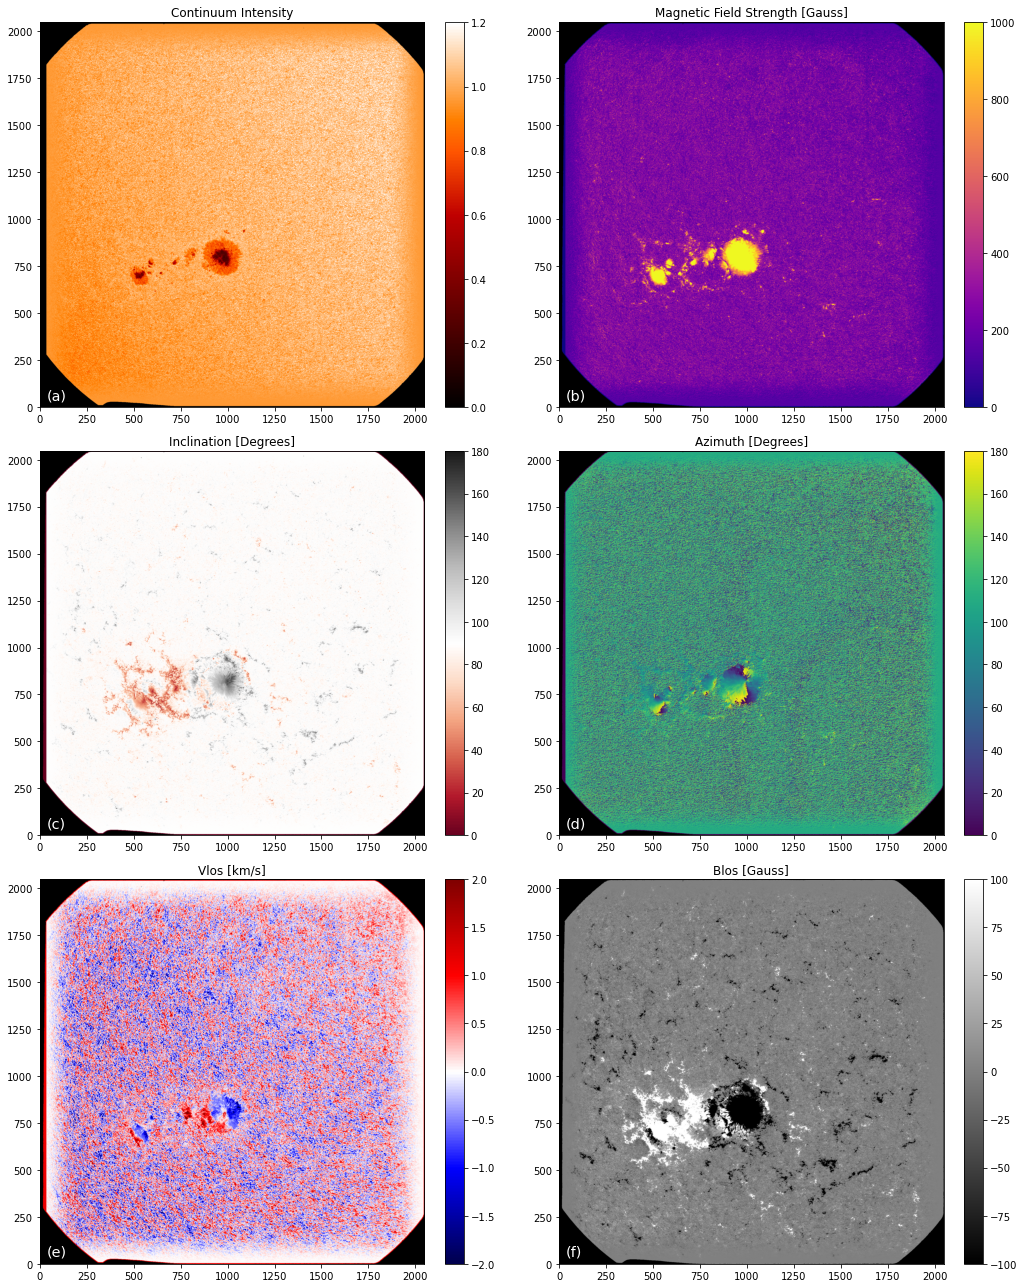

In [5]:
#show all data products, bmag, binc, bazi, blos, icnt
data_products_hrt = np.asarray([hrt_icnt, hrt_bmag, hrt_binc, hrt_bazi, hrt_vlos, hrt_blos])
plot_hrt_phys_obs(data_products_hrt)

## Edges

Notice how the edges appear different, ie white in Vlos. This is due to apodization for calibration purposes and will be improved in future.

## 3. Important to note: *Light Travel Time*

- Solar Orbiter is moving on an elliptical orbit, so its distance to the Sun will change over the course of its orbit.


- Should you want to compare this Solar Orbiter data to Earth-based instruments (eg: SDO/Hinode/SOHO) you might need to take care of light travel time

In [6]:
#Light travel Time, use DATE_EAR for light corrected (also DATE_SUN available)

hrt_hdr = fits.getheader(data_dir + "solo_L2_phi-hrt-blos_20220307T000009_V01.fits")
print("Date Observed : ", hrt_hdr["DATE-OBS"], "<--- This is the start time of the observation that SOAR queries on") 
print("Average Date  : ", hrt_hdr["DATE-AVG"], "<--- Notice the 23 second difference")
print("Light Travel Time Corrected: ", hrt_hdr["DATE_EAR"], "<--- Notice the ~ 4 minute difference")

Date Observed :  2022-03-07T00:00:09.388 <--- This is the start time of the observation that SOAR queries on
Average Date  :  2022-03-07T00:00:32.393 <--- Notice the 23 second difference
Light Travel Time Corrected:  2022-03-07T00:04:14.282 <--- Notice the ~ 4 minute difference


With a time difference of over 4 minutes, this is important when comparing SO/PHI data to that from other instruments, such as SDO/HMI, especially when you are using their high cadence (45second) observables.

Here you can also access this information from the `meta` attributes from the Sunpy `Map` object.

**Sidenote:** SDO is not at exactly 1AU, so this may make a difference when the PHI data product time (light corrected) lies in the middle between two SDO datasets

In [10]:
hrt_blos_map.meta['DATE_EAR']

'2022-03-07T00:04:14.282'

## 4. Image Stabilisation System (not relevant for SO/PHI-FDT)

- on SO/PHI-HRT increased pointing accuracy is required 

- hence an Image Stabilisation System (ISS) is available for the HRT channel only

- sometimes this system is turned off 

- when off this results in a slight noise level increase:

    - Stokes V noise from 1e-3 -->> ~1.3e-3

In [11]:
#Check if ISS on HRT is off or on

print("Image Stabilisation System Status: ", hrt_hdr["ISSMODE1"], " sunpy map method: ", hrt_blos_map.meta['ISSMODE1'])
print("ISS_IDLE means it was not operating")

Image Stabilisation System Status:  ISS_IDLE  sunpy:  ISS_IDLE
ISS_IDLE means it was not operating


## 5. Stokes Maps

- To produce the beautiful data products above, the Stokes information (which is what PHI measures) are put through the Radiative Transfer Equation Inversion (CMILOS)

- If you are interested in the raw Stokes Profiles, that is also available as a L2 data product

- PHI measures the Stokes IQUV vector at 5 wavelength points in the Fe1 6173A line, + one continuum wavelenght point (either red or blue dependent on the Spacecraft's velocity)

- $<I_c>$ here is the averaged Stokes **I** signal at the **C**ontinuum wavelength position

## HRT

#### reminder: hrt_stokes is 2048 x 2048 x 4 x 6 (y, x, stokes, wavelength)

We can retrieve the exact wavelength positions in Angstrom and the index of the continuum wavelength using `get_wv_arr_and_ic_wv` from `helper_functions.py`

For this HRT dataset, the continuum is on the red side ($+300m\AA$ from line centre)

In [13]:
hrt_wave_axis, _, hrt_cpos = get_wv_arr_and_ic_wv(data_dir + "solo_L2_phi-hrt-stokes_20220307T000009_V01.fits")
print("The wavelength positions are: ", hrt_wave_axis)
print("The continuum wavelength position is at index: ", hrt_cpos)

The wavelength positions are:  [6172.9535161 6173.0227222 6173.0922796 6173.1621883 6173.2317457
 6173.3887768]
The continuum wavelength position is at index:  5


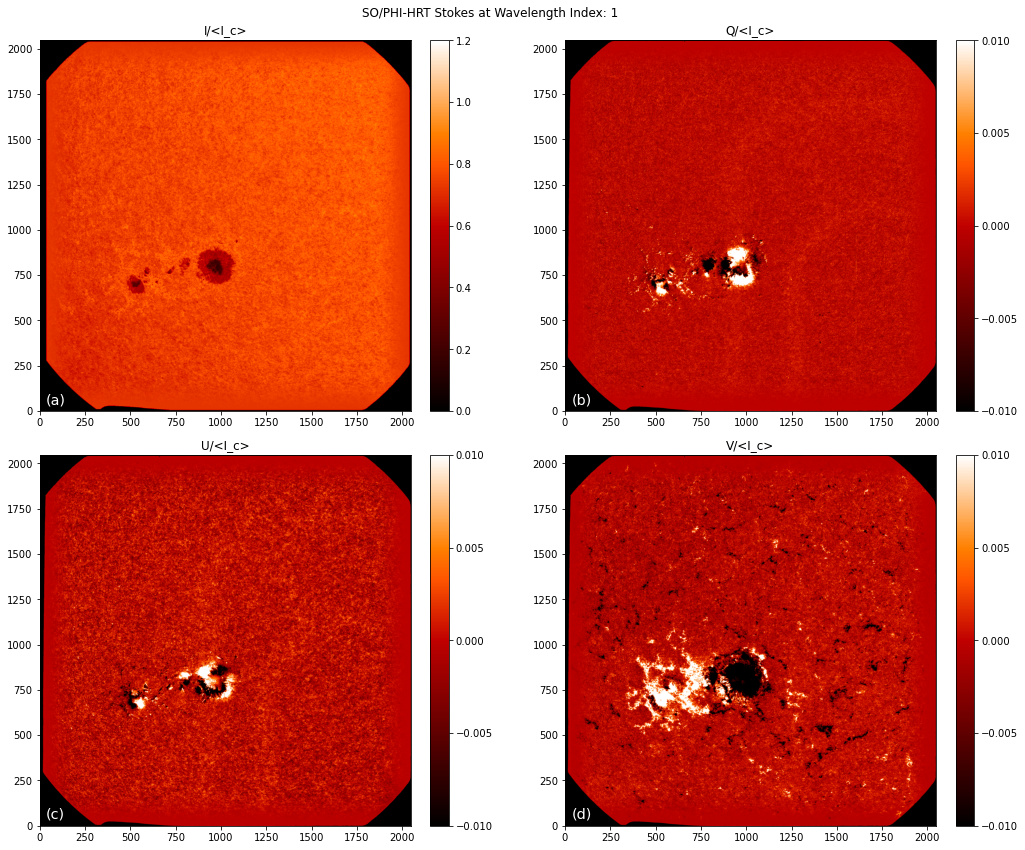

In [12]:
hrt_wv = 1 #between 0 and 5
plot_hrt_stokes(hrt_stokes, hrt_wv)

## 6. SO/PHI-HRT Noise Level Estimation

The noise level of SO/PHI-HRT has been published here: [Publication_link](https://arxiv.org/abs/2208.14904)

The Blos noise level is estimated from the standard deviation of a fitted normal (Gaussian) distribution to the Blos data. Likewise for Stokes V

Stokes V noise is: 1.1358e-03


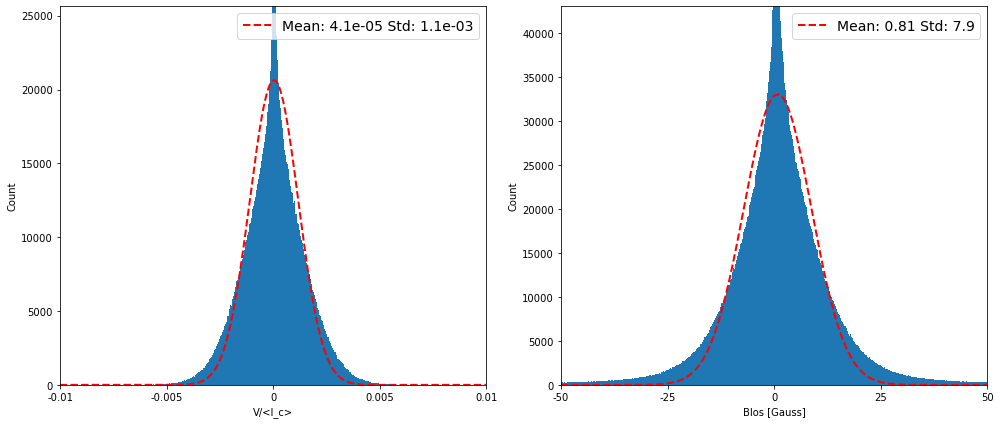

In [13]:
Stokes_V_vector = 3 #I,Q,U,V hence V index == 3
Continuum_wavelength = 5 #For this dataset the continuum is in the 5th wavelength position

plot_hrt_noise_both(hrt_stokes[:,:,Stokes_V_vector,Continuum_wavelength], hrt_blos)

## 7. SO/PHI-FDT + SDO/HMI Multi Instrument Mapping

Let's say you want to compare the Blos from SO/PHI-FDT to that from SDO/HMI. We therefore need to reproject SO/PHI-FDT onto the HMI Plane.

Here we load the HMI dataset that we want to work with. We create a sunpy `tmp_map` first, because we want to remove the pixels outside the HMI limb with a mask to create a good plot later.

We need to rotate the HMI map by around 180 degrees, to point Solar North up hence we use `.rotate()`

In [ ]:
#here we load the HMI Magnetogram that corresponds to the same time (light travel corrected!)
tmp_map = sunpy.map.Map("./static/hmi.m_45s.20220131_143215_TAI.2.magnetogram.fits").rotate()

Here the limb mask is created and applied to the `tmp_map` to create a new sunpy `map` object: `hmi_blos_map`

In [ ]:
#here we find the coordinators that are on the solar disk and create a mask
hpc_coords = sunpy.map.all_coordinates_from_map(tmp_map)
mask = ~sunpy.map.coordinate_is_on_solar_disk(hpc_coords)

#create the 'masked' sunpy map object
hmi_blos_map = sunpy.map.Map(tmp_map.data,tmp_map.meta, mask=mask)

Setting the colormap and limits for any subsequent plots generated later.

In [ ]:
#plotting details
hmi_blos_map.plot_settings['norm'].vmin = -100
hmi_blos_map.plot_settings['norm'].vmax = 100 
hmi_blos_map.plot_settings['cmap'] = plt.get_cmap('gray')

In [ ]:
fig = plt.figure(figsize = (14,14))

ax1 = fig.add_subplot(121, projection=hmi_blos_map)
hmi_blos_map.plot(axes=ax1)
hmi_blos_map.draw_limb(axes=ax1, color='blue')
fdt_blos_map.draw_limb(axes=ax1, color='red')

ax2 = fig.add_subplot(122, projection=fdt_blos_map)
fdt_blos_map.plot(axes=ax2)
limb_hmi = hmi_blos_map.draw_limb(axes=ax2, color='blue')
limb_fdt = fdt_blos_map.draw_limb(axes=ax2, color='red')
ax2.set_xlim(360,1050)
ax2.set_ylim(360,1050)
plt.legend([limb_hmi[0], limb_fdt[0]],
           ['Limb as seen by HMI', 'Limb as seen by FDT'])

First we can use the inbuilt reprojection algorithm in sunpy, which uses the WCS information within the header of the FITS file, to remap it onto the HMI's FOV.

We have to create an out_header using `sunpy.map.make_fitswcs_header` to be the output of the fdt remapped image.

In [ ]:
#Show how to rotate FDT onto HMI plane
out_shape = fdt_blos_map.data.shape

out_header = sunpy.map.make_fitswcs_header(
    out_shape,
    hmi_blos_map.reference_coordinate.replicate(rsun=fdt_blos_map.reference_coordinate.rsun),
    scale=u.Quantity(fdt_blos_map.scale),
    instrument="PHI",
    observatory="HMI Observer"
)

Now we apply the reprojection (this can take 30 seconds or longer)

In [ ]:
fdt_outmap = fdt_blos_map.reproject_to(out_header, algorithm = "adaptive")

Here the reprojected FDT map is plotted alongside the untouched HMI map. Here you can see that the reproject FDT image does not fill the full solar disk as seen on HMI (due to their different observation viewpoints).

In [ ]:
fig = plt.figure(figsize = (12,6))
ax1 = fig.add_subplot(121, projection=hmi_blos_map)
hmi_blos_map.plot(axes=ax1)
ax2 = fig.add_subplot(122, projection=fdt_outmap)
fdt_outmap.plot(axes=ax2, title='FDT image as seen from SDO', autoalign = True)
ax2.set_ylim(423,1000) #matching the axes limits of the HMI image
ax2.set_xlim(423,1000)
hmi_limb = hmi_blos_map.draw_limb(axes=ax2, color='red', label = "Limb as seen by HMI")

## 8. SO/PHI-HRT + SDO/HMI Multi Instrument Mapping

Here we can use the inferior conjunction data to compare HRT and HMI magnetograms with almost the same viewpoint on the Photosphere (still off by approximately 4 degrees). Again we create first a tmp map then mask the pixels outside the HMI limb. 

In [ ]:
#here we load the HMI Magnetogram that corresponds to the same time (light travel corrected!) and taking into account UTC vs TAI difference of 37 seconds
tmp_map_2 = sunpy.map.Map("./static/hmi.m_45s.20220307_000430_TAI.2.magnetogram.fits").rotate()

In [ ]:
#here we find the coordinators that are on the solar disk and create a mask
hpc_coords_2 = sunpy.map.all_coordinates_from_map(tmp_map_2)
mask_2 = ~sunpy.map.coordinate_is_on_solar_disk(hpc_coords_2)
#create the 'masked' sunpy map object
hmi_map = sunpy.map.Map(tmp_map_2.data,tmp_map_2.meta, mask=mask_2)

In [ ]:
hmi_map.plot_settings['norm'].vmin = -100
hmi_map.plot_settings['norm'].vmax = 100
hmi_map.plot_settings['cmap'] = plt.get_cmap('gray')

Now let's plot the two side by side as a comparison.

In [ ]:
fig = plt.figure(figsize = (14,14))

ax1 = fig.add_subplot(121, projection=hmi_map)
hmi_map.plot(axes=ax1)
hmi_map.draw_limb(axes=ax1, color='blue')

ax2 = fig.add_subplot(122, projection=hrt_blos_map)
hrt_blos_map.plot(axes=ax2)

Here we can plot the exact FOV of HRT on the HMI plane, using the `bottom_left_coord` and the `top_right_coord` attribute

In [ ]:
from astropy.coordinates import SkyCoord
from sunpy.coordinates import HeliographicStonyhurst

fig = plt.figure(figsize = (14,14))

ax1 = fig.add_subplot(121, projection=hmi_map)
hmi_map.plot(axes=ax1)
hmi_map.draw_limb(axes=ax1, color='white')
bottom_left = hrt_blos_map.bottom_left_coord
top_right = hrt_blos_map.top_right_coord
#note that the quadrangle approach is only appropriate when Solar Orbiter and HMI have the same pointing direction, otherwise this quadrangle will be incorrect
hmi_map.draw_quadrangle(bottom_left, top_right=top_right, axes = ax1, edgecolor='yellow') #width = 1024*u.arcsec, height = 1024*u.arcsec
ax2 = fig.add_subplot(122, projection=hrt_blos_map)
hrt_blos_map.plot(axes=ax2)